In [3]:
#! pip install datasets transformers seqeval pytorch_lightning mlflow livelossplot
# mlflow ui --backend-store-uri sqlite:///mlruns.db

In [4]:
from datasets import load_dataset, load_metric
import torch , tensorflow, time,os
import transformers
from transformers import AutoTokenizer ,AutoModel,AutoConfig

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback
import mlflow

%matplotlib inline
np.random.seed(0)
plt.style.use("ggplot")

In [5]:
task = "ner" # Should be one of "ner", "pos" or "chunk"
model_checkpoint = 'elastic/distilbert-base-cased-finetuned-conll03-english'
batch_size = 16

datasets = load_dataset("conll2003")

label_list = datasets["train"].features[f"{task}_tags"].feature.names

print('label list:',label_list)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
config = AutoConfig.from_pretrained(model_checkpoint)
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

Reusing dataset conll2003 (C:\Users\a809913\.cache\huggingface\datasets\conll2003\conll2003\1.0.0\40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6)


label list: ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']


In [6]:
label_all_tokens = True

In [7]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True,padding='max_length',max_length=128)

    labels = []
    for i, label in enumerate(examples[f"{task}_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to 9 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(9)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else 9)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [8]:
model_emb = AutoModel.from_pretrained(model_checkpoint)
tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)

Loading cached processed dataset at C:\Users\a809913\.cache\huggingface\datasets\conll2003\conll2003\1.0.0\40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6\cache-9e80465d630019ab.arrow
Loading cached processed dataset at C:\Users\a809913\.cache\huggingface\datasets\conll2003\conll2003\1.0.0\40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6\cache-53d20d6252e38c8c.arrow
Loading cached processed dataset at C:\Users\a809913\.cache\huggingface\datasets\conll2003\conll2003\1.0.0\40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6\cache-35f4d68b9f67e65e.arrow


In [9]:
label_list.append('PAD')

In [10]:
input_ids_train = torch.tensor(tokenized_datasets["train"][:250]['input_ids'])
masks_train = torch.tensor(tokenized_datasets["train"][:250]['attention_mask'])
emb_train = model_emb(input_ids = input_ids_train, attention_mask=masks_train)
label_train = torch.tensor(tokenized_datasets["train"][:250]['labels'])

In [11]:
emb_train['last_hidden_state'].shape , label_train.shape

(torch.Size([250, 128, 768]), torch.Size([250, 128]))

In [12]:
input_ids_test = torch.tensor(tokenized_datasets["train"][250:350]['input_ids'])
masks_test = torch.tensor(tokenized_datasets["train"][250:350]['attention_mask'])
emb_test = model_emb(input_ids = input_ids_test, attention_mask=masks_test)
label_test = torch.tensor(tokenized_datasets["train"][250:350]['labels'])

In [13]:
emb_test['last_hidden_state'].shape , label_test.shape

(torch.Size([100, 128, 768]), torch.Size([100, 128]))

In [14]:
x_train = tensorflow.convert_to_tensor(emb_train['last_hidden_state'].detach().numpy())
y_train = tensorflow.convert_to_tensor(label_train.detach().numpy())

x_test = tensorflow.convert_to_tensor(emb_test['last_hidden_state'].detach().numpy())
y_test = tensorflow.convert_to_tensor(label_test.detach().numpy())

In [15]:
x_train.shape, x_test.shape

(TensorShape([250, 128, 768]), TensorShape([100, 128, 768]))

In [16]:
tokenizer.save_pretrained('./tokenizer')
config.save_pretrained('./tokenizer')
model_emb.save_pretrained('./Emb_model')

In [17]:
import pickle

with open('label_list', 'wb') as fp:
    pickle.dump(label_list, fp)

In [18]:
with open ('label_list', 'rb') as fp:
    itemlist = pickle.load(fp)
itemlist

['O',
 'B-PER',
 'I-PER',
 'B-ORG',
 'I-ORG',
 'B-LOC',
 'I-LOC',
 'B-MISC',
 'I-MISC',
 'PAD']

In [19]:
max_len = 128
input_word = Input(shape=(max_len,768))
model = Dense(200)(input_word)
out = Dense(10, activation="softmax")(model)
model = Model(input_word, out)
model.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('f1')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 768)]        0         
_________________________________________________________________
dense (Dense)                (None, 128, 200)          153800    
_________________________________________________________________
dense_1 (Dense)              (None, 128, 10)           2010      
Total params: 155,810
Trainable params: 155,810
Non-trainable params: 0
_________________________________________________________________


In [20]:
early_stopping = EarlyStopping(monitor='f1', min_delta=0, patience=5, verbose=0, mode='max', baseline=None, restore_best_weights=False)
callbacks = [PlotLossesCallback(), early_stopping]

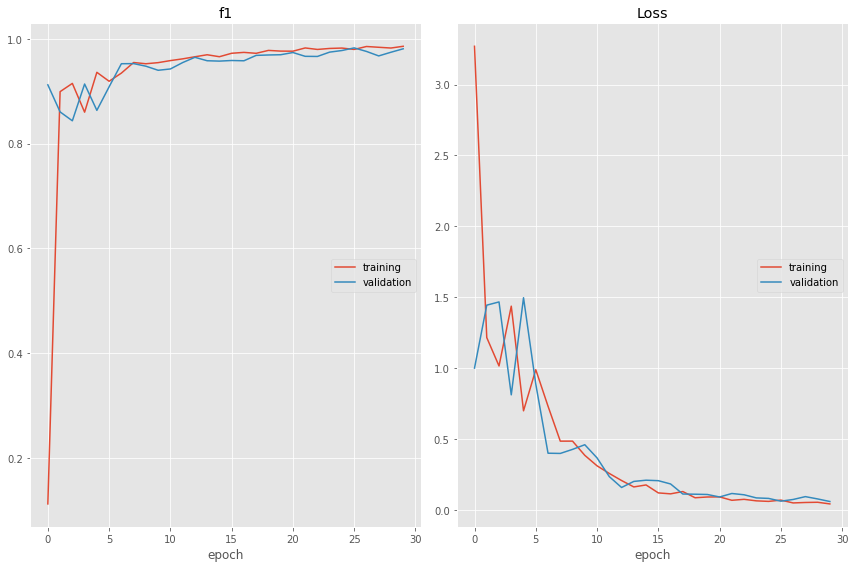

f1
	training         	 (min:    0.112, max:    0.986, cur:    0.986)
	validation       	 (min:    0.844, max:    0.983, cur:    0.981)
Loss
	training         	 (min:    0.041, max:    3.271, cur:    0.041)
	validation       	 (min:    0.058, max:    1.496, cur:    0.058)
INFO:tensorflow:Assets written to: C:\Users\a809913\AppData\Local\Temp\tmp_w0pa77n\model\data\model\assets
1/1 [==============================] - 0s 85ms/step - loss: 0.0580 - f1: 0.9812


In [21]:
mlflow.set_tracking_uri("https://localhost:8000")
mlflow.tensorflow.autolog()
with mlflow.start_run() as run :
    run_uuid = run.info.run_uuid
    print("MLflow Run ID: %s" % run_uuid)
    start = time.time()
    history = model.fit(
          x = x_train,
          y = y_train,
          validation_data=(x_test,y_test),
          batch_size=220, 
          epochs=30,
          callbacks=callbacks,
          verbose=1,
      )
    mlflow.log_metric("Training time", time.time() - start)
    results = model.evaluate(x = x_test, y=y_test, steps=1,  batch_size=220)
    mlflow.log_metric("test_loss", results[0])
    mlflow.log_metric("test_F1", results[1])
    
    mlflow.log_artifact("label_list", artifact_path="label_list")
    
    if os.path.exists("./Drift_model"):
        mlflow.log_artifacts("./Drift_model", artifact_path="drift")
        
    if os.path.exists("./Emb_model"):
        mlflow.log_artifacts("./Emb_model", artifact_path="emb")
        
    if os.path.exists("./tokenizer"):
        mlflow.log_artifacts("./tokenizer", artifact_path="tokenizer")

In [22]:
idx = 90

In [23]:
sentence = ' '.join(tokenized_datasets["train"][idx]['tokens'])
sentence

'Port conditions update - Syria - Lloyds Shipping .'

In [24]:
input_id = torch.tensor(tokenized_datasets["train"][idx:idx+1]['input_ids'])
mask = torch.tensor(tokenized_datasets["train"][idx:idx+1]['attention_mask'])

In [25]:
x = tensorflow.convert_to_tensor(model_emb(input_ids=input_id,attention_mask=mask)['last_hidden_state'].detach().numpy())

In [26]:
y = model(x)

In [27]:
y = tf.argmax(y,axis=-1).numpy().squeeze().tolist()

In [28]:
words = tokenizer.convert_ids_to_tokens(tokenized_datasets["train"][idx]['input_ids'])

In [29]:
label_list

['O',
 'B-PER',
 'I-PER',
 'B-ORG',
 'I-ORG',
 'B-LOC',
 'I-LOC',
 'B-MISC',
 'I-MISC',
 'PAD']

In [30]:
l=[]
for i in range (len(words)):
    if words[i] != '[PAD]' : 
        l.append({words[i]:label_list[y[i]]})


In [31]:
l

[{'[CLS]': 'PAD'},
 {'Port': 'O'},
 {'conditions': 'O'},
 {'update': 'O'},
 {'-': 'O'},
 {'Syria': 'B-LOC'},
 {'-': 'O'},
 {'Lloyd': 'PAD'},
 {'##s': 'B-ORG'},
 {'Shipping': 'I-ORG'},
 {'.': 'PAD'},
 {'[SEP]': 'PAD'}]

In [32]:
#!zip -r mlruns.zip mlruns/

In [33]:
"""from google.colab import files
files.download('mlruns.zip')
files.download('mlruns.db')"""

"from google.colab import files\nfiles.download('mlruns.zip')\nfiles.download('mlruns.db')"

In [34]:
text = ["John lives in Paris, which is the capital and most populous city of France"]

def preproccess(text,tokenizer,model,max_len):
    tokenized = tokenizer(text, truncation=True, padding='max_length',max_length=max_len)
    input_id = torch.tensor(tokenized['input_ids'])
    mask = torch.tensor(tokenized['attention_mask'])
    out = model_emb(input_ids = input_id, attention_mask=mask)['last_hidden_state']
    return  tensorflow.convert_to_tensor(out.detach().numpy()),input_id.numpy().squeeze().tolist(),mask.numpy().squeeze().tolist()

def predict(text,model,tokenizer,model_emb,max_len,label_list):
    input =  preproccess(text,tokenizer,model_emb,max_len)
    y = model(input[0])
    y = tf.argmax(y,axis=-1).numpy().squeeze().tolist()
    words = tokenizer.convert_ids_to_tokens(input[1])
    l=[]
    for i in range (len(words)):
        if input[2][i] == 0 :
            break
        l.append({words[i]:label_list[y[i]]})
    return l
    

In [35]:
predict(text,model,AutoTokenizer.from_pretrained('tokenizer/'),AutoModel.from_pretrained('Emb_model/'),max_len,label_list)

[{'[CLS]': 'PAD'},
 {'John': 'B-PER'},
 {'lives': 'O'},
 {'in': 'O'},
 {'Paris': 'B-LOC'},
 {',': 'O'},
 {'which': 'O'},
 {'is': 'O'},
 {'the': 'O'},
 {'capital': 'O'},
 {'and': 'O'},
 {'most': 'O'},
 {'populous': 'O'},
 {'city': 'O'},
 {'of': 'O'},
 {'France': 'B-LOC'},
 {'[SEP]': 'PAD'}]